# MAKING A 3D LIP LANDMARKS MODEL (using Mahesh Babu)

# 1. Read all landmarks

In [4]:
from exchange_dialogues_functions import *

config = MovieTranslationConfig()

In [5]:
language = 'telugu'
actor = 'Mahesh_Babu'

In [6]:
landmarks_dir = os.path.join(config.MOVIE_TRANSLATION_DATASET_DIR, 'landmarks', language, actor)

In [11]:
landmarks_files = sorted(glob.glob(os.path.join(landmarks_dir, '*')))
num_of_landmark_files = len(landmarks_files)

In [43]:
Mahesh_Babu_3D_landmarks = np.empty((0, 68, 3))

for i in tqdm.tqdm(range(num_of_landmark_files)):
    video_3D_landmarks_full = utils.read_landmarks(language, actor, i, '3D')
    video_3D_landmarks = [lm_full[1:] for lm_full in video_3D_landmarks_full if len(lm_full) == 69]
    Mahesh_Babu_3D_landmarks = np.vstack((Mahesh_Babu_3D_landmarks, np.array(video_3D_landmarks)))

100%|██████████| 194/194 [00:48<00:00,  4.03it/s]


In [44]:
Mahesh_Babu_3D_landmarks.shape

(14231, 68, 3)

# 2. Choose a frame to make straight face model

I choose Mahesh_Babu_0060_frame_040.png

In [51]:
ref_frame = cv2.cvtColor(cv2.imread(os.path.join(config.MOVIE_TRANSLATION_DATASET_DIR, 'frames', 'telugu', 'Mahesh_Babu', 'Mahesh_Babu_0060', 'Mahesh_Babu_0060_frame_040.png')), cv2.COLOR_BGR2RGB)

In [56]:
ref_3D_landmarks = np.array(utils.read_landmarks('telugu', 'Mahesh_Babu', 60, '3D')[40][1:])

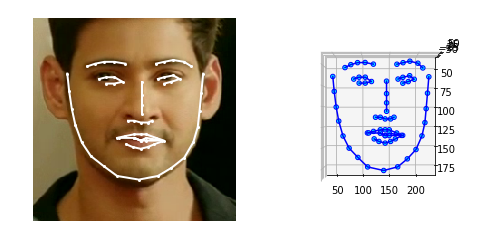

In [57]:
utils.plot_3D_landmarks(ref_frame, ref_3D_landmarks)

# 3. Tranform all 3D landmarks to match the pose & location of reference frame

For example, consider the 282nd landmarks of Mahesh Babu:

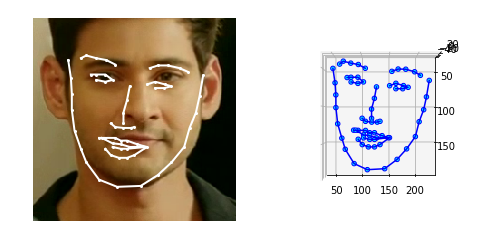

In [92]:
utils.plot_3D_landmarks(ref_frame, Mahesh_Babu_3D_landmarks[282])

I estimate the affine Tx required to change the 282nd pose to match that of the reference frame, and apply that Tx.

In [93]:
src_3D_landmarks = Mahesh_Babu_3D_landmarks[282]

# Estimate affine Tx
retval, Rt_to_dst_from_src, _ = cv2.estimateAffine3D(src_3D_landmarks[:36], ref_3D_landmarks[:36])

# Make homogeneous ccoordinates
src_homogeneous_coords = np.hstack(( src_3D_landmarks, np.ones((68, 1)) ))

# Apply Tx
target_lip_landmarks_tx_from_source = np.dot( Rt_to_dst_from_src, src_homogeneous_coords.T ).T.astype('int')

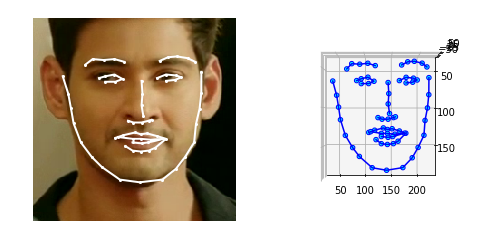

In [94]:
utils.plot_3D_landmarks(ref_frame, target_lip_landmarks_tx_from_source)

In this way, Tx all 3D landmarks.

In [95]:
def affine_3D_tx(source_3D_landmarks, target_3D_landmarks):
    retval, Rt_to_dst_from_src, _ = cv2.estimateAffine3D(source_3D_landmarks[:36], target_3D_landmarks[:36])
    return np.dot( Rt_to_dst_from_src, np.hstack(( source_3D_landmarks, np.ones((68, 1)) )).T ).T.astype('int')

In [99]:
# # Tx all landmarks
# Mahesh_Babu_3D_landmarks_tx_to_ref = np.array([affine_3D_tx(lm, ref_3D_landmarks) for lm in Mahesh_Babu_3D_landmarks])
# np.savez('Mahesh_Babu_3D_landmarks_and_tx_to_ref',
#          Mahesh_Babu_3D_landmarks=Mahesh_Babu_3D_landmarks,
#          ref_3D_landmarks=ref_3D_landmarks,
#          Mahesh_Babu_3D_landmarks_tx_to_ref=Mahesh_Babu_3D_landmarks_tx_to_ref)

# Load all Tx landmarks
Mahesh_Babu_3D_landmarks_and_tx_to_ref = np.load('Mahesh_Babu_3D_landmarks_and_tx_to_ref.npz')
Mahesh_Babu_3D_landmarks = Mahesh_Babu_3D_landmarks_and_tx_to_ref['Mahesh_Babu_3D_landmarks']
ref_3D_landmarks = Mahesh_Babu_3D_landmarks_and_tx_to_ref['ref_3D_landmarks']
Mahesh_Babu_3D_landmarks_tx_to_ref = Mahesh_Babu_3D_landmarks_and_tx_to_ref['Mahesh_Babu_3D_landmarks_tx_to_ref']

# 4. Cluster all Tx lip landmarks

Now that we have Tx all lip landmarks to have same pose, let us cluster them.

In [101]:
# Reshape to make all 68 landmarks in each row
Mahesh_Babu_3D_landmarks_tx_to_ref_reshaped = np.reshape(Mahesh_Babu_3D_landmarks_tx_to_ref, (len(Mahesh_Babu_3D_landmarks_tx_to_ref), -1))

In [102]:
Mahesh_Babu_3D_landmarks_tx_to_ref_reshaped.shape

(14231, 204)

### Visualize landmarks using t-SNE

In [155]:
# Choose random 10000 points to display
display_num = 1000
random_choice = np.random.choice(len(Mahesh_Babu_3D_landmarks_tx_to_ref_reshaped), display_num)
random_lip_landmarks = Mahesh_Babu_3D_landmarks_tx_to_ref_reshaped[random_choice][:, 48:68]

In [156]:
from sklearn.manifold import TSNE
random_lip_landmarks_tsne = TSNE(n_components=2, verbose=1).fit_transform(random_lip_landmarks)
# plt.plot(random_landmarks)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.666310
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.107780
[t-SNE] Error after 1000 iterations: 1.435198


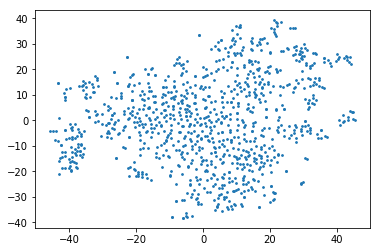

In [157]:
# 1000 points
plt.scatter(random_lip_landmarks_tsne[:, 0], random_lip_landmarks_tsne[:, 1], s=3)

## Apply Spectral Clustering to the lips
http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering

In [150]:
import sklearn.cluster

spectral_cluster_params = {
    'n_clusters'    : 18,
    'eigen_solver'  : None,
    'affinity'      : 'nearest_neighbors',
    'n_neighbors'   : 10,
    'assign_labels' : 'discretize'
}

spectral = sklearn.cluster.SpectralClustering(n_clusters=spectral_cluster_params['n_clusters'],
                                              eigen_solver=spectral_cluster_params['eigen_solver'],
                                              affinity=spectral_cluster_params['affinity'],
                                              n_neighbors=spectral_cluster_params['n_neighbors'],
                                              assign_labels=spectral_cluster_params['assign_labels'])

# Fit on only mouth
spectral.fit(Mahesh_Babu_3D_landmarks_tx_to_ref_reshaped[:, 48:68])

SpectralClustering(affinity='nearest_neighbors', assign_labels='discretize',
          coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=18, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [151]:
# Save cluster
from sklearn.externals import joblib
joblib.dump(spectral, 'spectral_cluster.pkl', compress=3)

['spectral_cluster.pkl']

In [152]:
labels = spectral.labels_.astype(np.int)
unique_labels = np.unique(labels)
print(unique_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [153]:
# Cluster centres
cluster_centers = []
for i in range(len(unique_labels)):
    cluster_centers.append(np.mean(Mahesh_Babu_3D_landmarks_tx_to_ref_reshaped[labels == i], axis=0))
    
cluster_centers = np.array(cluster_centers)

In [154]:
np.save('cluster_centers', cluster_centers)

### Visualize clusters using t-SNE

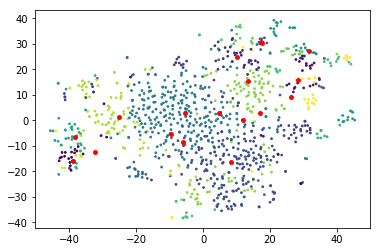

In [158]:
# Plot tSNE clusters
random_labels = labels[random_choice]
random_lip_cluster_centers = []
for i in range(len(unique_labels)):
    random_lip_cluster_centers.append(np.mean(random_lip_landmarks_tsne[random_labels == i], axis=0))
    
random_lip_cluster_centers = np.array(random_lip_cluster_centers)

plt.scatter(random_lip_landmarks_tsne[:, 0], random_lip_landmarks_tsne[:, 1], s=3, c=random_labels)
plt.scatter(random_lip_cluster_centers[:, 0], random_lip_cluster_centers[:, 1], s=15, c='r')

# 5. Plot the landmarks at the cluster centers

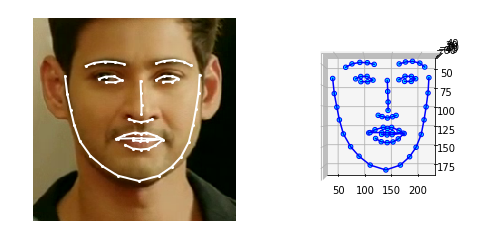

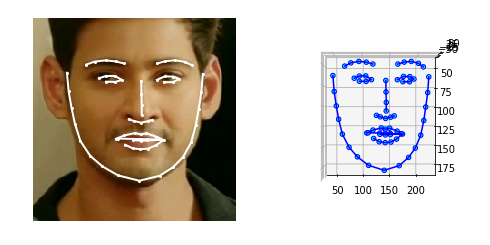

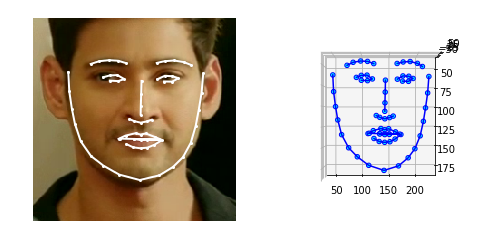

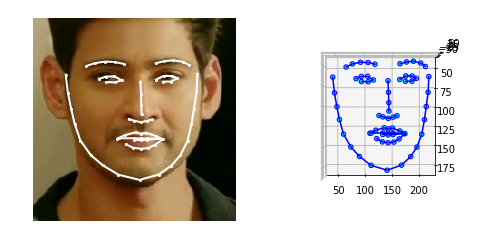

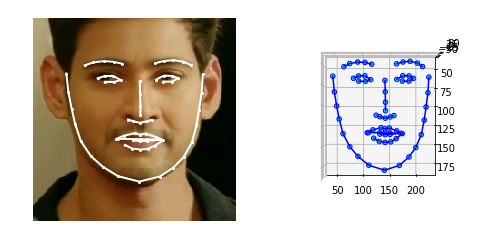

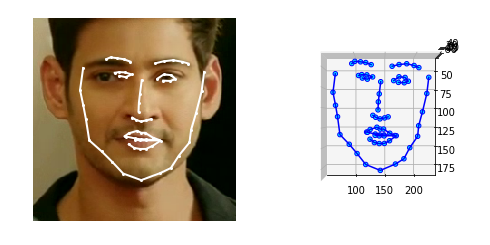

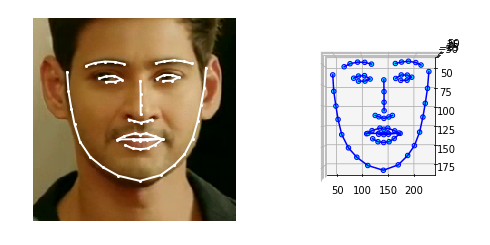

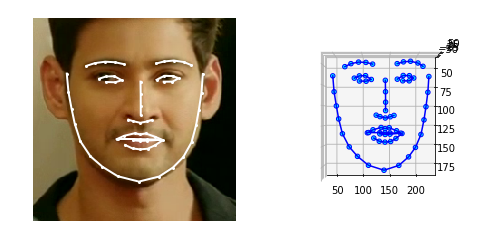

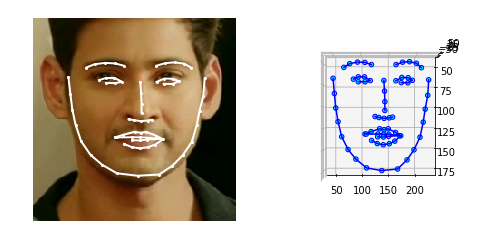

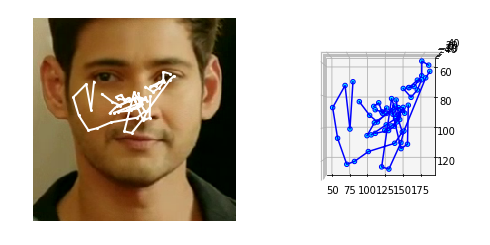

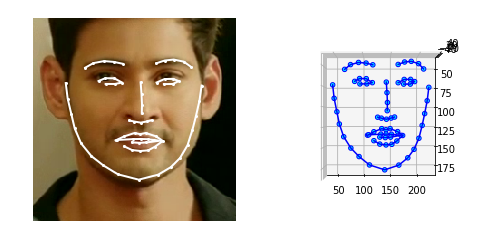

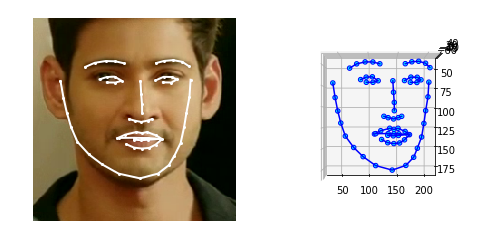

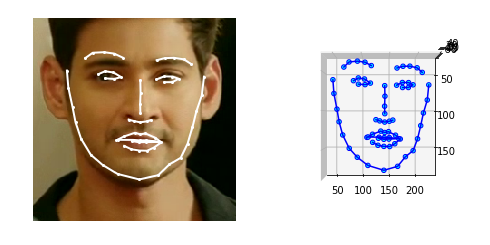

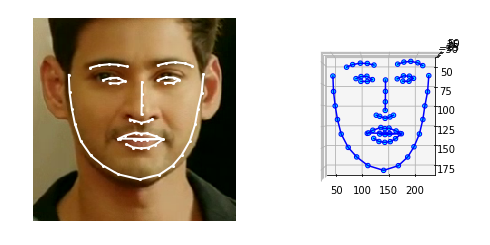

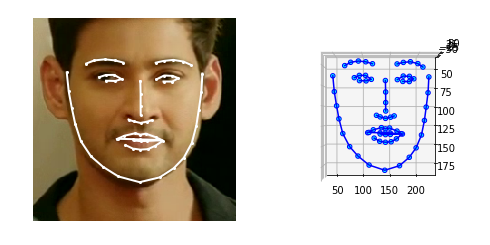

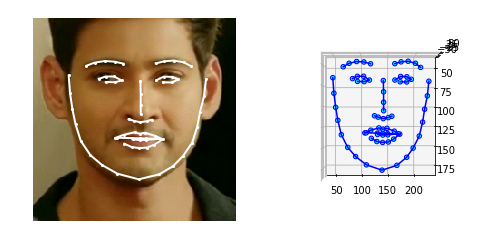

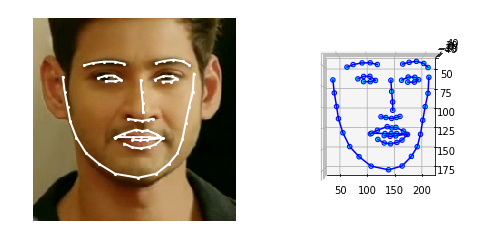

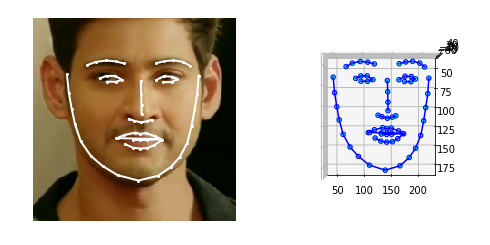

In [159]:
for i in range(len(cluster_centers)):
    utils.plot_3D_landmarks(ref_frame, cluster_centers[i].reshape(68, 3))

### Check for scale

Consider a smaller face's landmarks. Check if Affine Tx works.

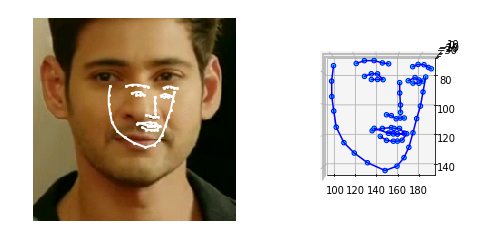

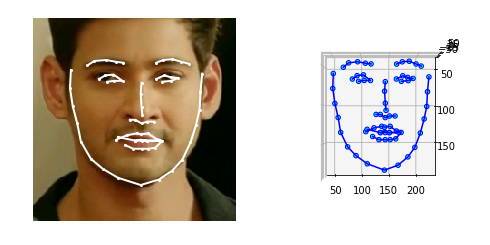

In [70]:
# Make src_3D_landmarks smaller
src_3D_landmarks = Mahesh_Babu_3D_landmarks[100]
src_3D_landmarks_mean = np.mean(src_3D_landmarks, axis=0)
src_3D_landmarks_smaller = (src_3D_landmarks - src_3D_landmarks_mean)/2 + src_3D_landmarks_mean
utils.plot_3D_landmarks(ref_frame, src_3D_landmarks_smaller)

# Estimate Affine 3D Tx
retval, Rt_to_dst_from_src, _ = cv2.estimateAffine3D(src_3D_landmarks_smaller[:36], ref_3D_landmarks[:36])
# Make homogeneous ccoordinates
src_homogeneous_coords = np.hstack(( src_3D_landmarks_smaller, np.ones((68, 1)) ))
# Apply Tx
target_lip_landmarks_tx_from_source = np.dot( Rt_to_dst_from_src, src_homogeneous_coords.T ).T.astype('int')

utils.plot_3D_landmarks(ref_frame, target_lip_landmarks_tx_from_source)